<a href="https://colab.research.google.com/github/punkmic/Predict-survival-on-the-Titanic-with-XGBoost/blob/master/Predict_survival_on_the_Titanic_with_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predicting who survives on the Titanic with XGBoost**

**Titanic**

The RMS Titanic was a passenger ship that collided with an iceberg on April 14, 1912, during its maiden voyage from Southampton, England to New York City. The accident resulted in the deaths of more than 1,500 people, making it one of the deadliest maritime disasters in history.

**XGBoost**

XGBoost is an open-source software library for gradient boosting, a machine learning technique for regression and classification tasks. It was developed by Tianqi Chen at the University of Washington and has become one of the most widely used machine learning libraries in the world. XGBoost uses an optimized implementation of gradient boosting that is designed to be faster and more accurate than other gradient boosting libraries. Gradient boosting involves building a series of decision trees, with each tree learning from the mistakes made by the previous trees.

## **Clone remote repository from [Github](https://github.com)**

In [270]:
!git clone https://github.com/punkmic/Predict-survival-on-the-Titanic-with-XGBoost.git

fatal: destination path 'Predict-survival-on-the-Titanic-with-XGBoost' already exists and is not an empty directory.


## **Import and install libraries**

In [271]:
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import r2_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay
try:
  import xgboost as xgb
except:
  !pip install xgboost

## **Load dataset using fetch_openml method from sklean**

In [272]:
DATASET = "titanic"
X, y = fetch_openml(DATASET, version=1, as_frame=True, return_X_y=True)
X.drop(['boat', 'body', 'home.dest'], axis=1, inplace=True)

## **Print table of features**

In [273]:
# read table features
pd.read_csv('/content/Predict-survival-on-the-Titanic-with-XGBoost/tintanic_features.csv')

,Variable,Definition,Key
0,survival,Survival,"0 = No, 1 = Yes"
1,pclass,Ticket class,"1 = 1st, 2 = 2nd, 3 = 3rd"
2,sex,Sex,NaN
3,Age,Age in years,NaN
4,sibsp,# of siblings / spouses aboard the Titanic,NaN
5,parch,# of parents / children aboard the Titanic,NaN
6,ticket,Ticket number,NaN
7,fare,Passenger fare,NaN
8,cabin,Cabin number,NaN
9,embarked,Port of Embarkation,"C = Cherbourg, Q = Queenstown, S = Southampton"


## **Split data into train, validation and test**

In [274]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# split data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [275]:
# Print information
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 981 entries, 1216 to 2
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    981 non-null    float64 
 1   name      981 non-null    object  
 2   sex       981 non-null    category
 3   age       782 non-null    float64 
 4   sibsp     981 non-null    float64 
 5   parch     981 non-null    float64 
 6   ticket    981 non-null    object  
 7   fare      980 non-null    float64 
 8   cabin     212 non-null    object  
 9   embarked  981 non-null    category
dtypes: category(2), float64(5), object(3)
memory usage: 71.1+ KB


In [276]:
# Print the first top 3 rows
X_train.head(3)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
1216,3.0,"Smyth, Miss. Julia",female,NaN,0.0,0.0,335432,7.7333,None,Q
819,3.0,"Glynn, Miss. Mary Agatha",female,NaN,0.0,0.0,335677,7.7500,None,Q
1286,3.0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0.0,0.0,2688,7.2292,None,C


## **Remove missing values**


In [277]:
# Check missing values
X_train.isnull().sum() / len(X_train) * 100

pclass       0.000000
name         0.000000
sex          0.000000
age         20.285423
sibsp        0.000000
parch        0.000000
ticket       0.000000
fare         0.101937
cabin       78.389399
embarked     0.000000
dtype: float64

Observe that approximately 78% of rows have no information about the cabin that's said let's drop rows having missing cabin value.

In [278]:
# Drop cabin feature
X_train.drop(['cabin'], axis=1, inplace=True)
X_test.drop(['cabin'], axis=1, inplace=True)

## **Compute correlation between features**

Correlation is a statistical measure that describes the strength of a linear relationship between two variables. It can be useful for selecting features to feed into a machine learning model, as highly correlated features may contain redundant information and can negatively impact model performance.

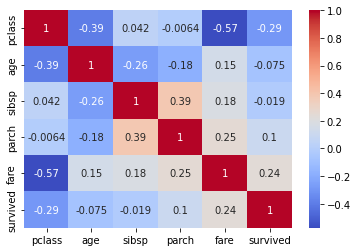

In [279]:
# Concat X_train and y_train
X_comb = pd.concat([X_train, y_train.astype(float)], axis=1)

# Compute the Pearson correlation coefficient between the features
corr = X_comb.corr(method='pearson')

# Plot the correlation heatmap
sns.heatmap(corr, annot=True, cmap = "coolwarm")
plt.show()

As the heatmap shows, there is a weak correlation between parch and sibsp features. One way to solve this problem is to use feature engineering to create a new feature. Feature engineering is the process of designing and creating features that can be used to train machine learning models. It involves selecting relevant features from raw data, extracting and constructing new features from existing ones, and transforming features to make them more suitable for modeling.

## **Feature Engineering**

We can combine parch and sibsp into a new feature, called family_size. After we create a new feature called single_person and set 1 if the passenger is alone in the ship or 0 if not.

In [280]:
for dataset in [X_train, X_test]:
    dataset['family_size'] = dataset['parch'] + dataset['sibsp']
    dataset.drop(['parch', 'sibsp'], axis=1, inplace=True)
    dataset['single_person'] = 1
    dataset['single_person'].loc[dataset['family_size'] > 1] = 0

X_train.head()

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,pclass,name,sex,age,ticket,fare,embarked,family_size,single_person
1216,3.0,"Smyth, Miss. Julia",female,NaN,335432,7.7333,Q,0.0,1
819,3.0,"Glynn, Miss. Mary Agatha",female,NaN,335677,7.7500,Q,0.0,1
1286,3.0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,2688,7.2292,C,0.0,1
1280,3.0,"Vovk, Mr. Janko",male,22.0,349252,7.8958,S,0.0,1
761,3.0,"de Pelsmaeker, Mr. Alfons",male,16.0,345778,9.5000,S,0.0,1


## **Pipeline**

### Fill missing values using Scikit-learn Pipelines

**Categorical features**

Now let's use scikit-learn Pipeline class with three steps: inputer, one hot encoder and principal component analysis. First, we are going to replace missing values using the SimpleImputer transformer class, Then, we are going to transform categorical features into numerical using the OneHotEncoder transformer class as most machine learning models cannot accept non-numerical values as input. Finally, we are going to apply principal component analysis technique using the PCA class.  PCA has a n_components parameter which specifies the number of principal components to keep when using the PCA class for dimensionality reduction. Here we are going to pass 10 as argument.

In [281]:
categorical_cols = ['embarked', 'sex', 'pclass', 'name', 'single_person']

cat_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                               ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)),
                               ('reducer', PCA(n_components=10, random_state=42))])

**Pipeline** is a class which allows you to chain multiple processing steps together and apply them to a dataset in a single, convenient object. Pipelines are a collection of tuples containing a name and an estimator object. The estimator object can be a transforme which applies a transformation to the data or model.

**SimpleInputer** is a class that fill missing values using the argument passed to it's strategy parameter. SimpleImputer class accepts three different strategy option: mean, median, or most frequent value of each column.

**OneHotEncoder** is a transformer class that converts categorical variables into a numerical format that can be used in machine learning models. It does this by creating a new binary column for each unique category in the data.

**Principal Component Analysis (PCA)** PCA is a technique for dimensionality reduction which identifies the most important features also called principal components in machine learning. It is a linear transformation that projects the data onto a lower-dimensional space while preserving as much of the original variance as possible.



**Numerical features**

Again we are going to use scikit-learn Pipeline to replace missing values and apply normalization.

In [282]:
numerical_cols = ['age', 'fare', 'family_size']
num_pipeline = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5)),
                               ('scaler', RobustScaler())])

**KNNImputer** is a transformer class that uses the k-Nearest Neighbors algorithm to impute missing values based on the values of the nearest neighbors in the feature. It can be more accurate than SimpleImputer, but it is also slower to fit and transform the data. 

**RobustScaler** is a transformer class that scale numerical features using statistics that are robust to outliers, such as the median and interquartile range. It is very useful when the data has a high level of noise or outliers. Scaling the features is important for several reasons: 1) Some models are sensitive to the scale of the features, and can perform poorly if the features are not scaled 2) Scaling the features can help to normalize the data and make it more suitable for certain types of models 3) Scaling the features can also help to reduce the impact of outliers or skewed distributions in the data.

**Putting all together**

In [283]:
col_transformer = ColumnTransformer(transformers=[('numerical', num_pipeline, numerical_cols),('categorical', cat_pipeline, categorical_cols)])

# create a pipeline that transform data and make predictions
pipeline = Pipeline(steps=[('col_transformer', col_transformer), ('classifier', xgb.XGBClassifier(random_state=10))])

**ColumnTransformer** is a class that applies different transformations to different columns of a dataset, and it can be used as part of a scikit-learn pipeline to streamline your machine learning workflow.

## **Train model**

In [284]:
# fit the pipeline to the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['age', 'fare',
                                                   'family_size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
        

## **Model evaluation before hyperparameter optimization**

In [285]:
# create the cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=9, n_repeats=3, random_state=0)
cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="accuracy").mean()

0.7978253482840637

In [286]:
def find_best_split(splits= list(range(2,20))):
  scores = []
  best_score = 0
  best_split = 0
  for n in splits:
    cv = RepeatedStratifiedKFold(n_splits=n, n_repeats=3, random_state=0)
    score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="accuracy").mean()
    scores.append(score)
    if score > best_score:
      best_score = score
      best_split = n

  plt.plot(splits, scores)
  plt.xlabel('Number of Splits')
  plt.ylabel('Cross-Validated Accuracy')
  plt.show()
  print()
  print(f"Best split number: {best_split}")
  return best_split


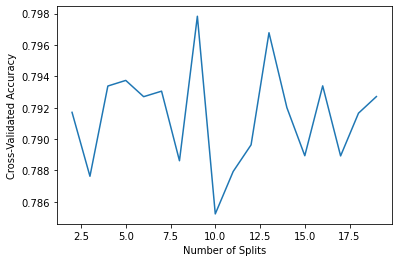


Best split number: 9

Accuracy: 0.7978253482840637


In [287]:
n_split = find_best_split(splits= list(range(2,20)))
cv = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=3, random_state=0)
accuracy = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="accuracy").mean()
print()
print(f"Accuracy: {accuracy}")

**RepeatedStratifiedKFold** is a cross-validation strategy that can be used to evaluate the performance of a machine learning model. It is a variation of the StratifiedKFold strategy, with the added ability to run the cross-validation process multiple times with different random splits of the data. In RepeatedStratifiedKFold, the data is split into K folds, where K is specified by the user. The StratifiedKFold strategy ensures that the proportion of samples belonging to each class is approximately the same across all the folds. This is useful when the classes are imbalanced, as it helps to ensure that all the classes are represented in each fold.

## **Hyperparameter Search**

Hyperparameter search, also known as hyperparameter optimization, is the process of tuning the hyperparameters of a machine learning model to achieve the best performance on a given dataset. Hyperparameters are values that are set prior to training a model and control the behavior and learning process of the model. Examples of hyperparameters include the learning rate (learning_rate), maximum depth (max_depth), and the number of estimators (n_estimators) in a XGBoost model.

In [288]:
xgb_dist = {'classifier__learning_rate': uniform(0.01, 0.1),
              'classifier__max_depth': range(3, 10),
              'classifier__n_estimators': range(50, 200),
              'classifier__subsample': uniform(0.5, 0.5),
              'classifier__colsample_bytree': uniform(0.5, 0.5),
              'classifier__reg_lambda': uniform(0, 1)}

num_transformer_dist = {'col_transformer__numerical__imputer__n_neighbors': list(range(2, 25)),
                        'col_transformer__numerical__imputer__add_indicator': [True, False]}

cat_transformer_dist = {'col_transformer__categorical__imputer__strategy': ['most_frequent', 'constant'],
                        'col_transformer__categorical__imputer__add_indicator': [True, False],
                        'col_transformer__categorical__reducer__n_components': list(range(2, 25))}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **xgb_dist}

# Create the cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=n_split, n_repeats=3, random_state=0)

# create a RandomizedSearchCV object
random_search = RandomizedSearchCV(pipeline, param_dist, cv=cv, scoring='accuracy', n_iter=10) # scoring = 'accuracy' 'roc_auc'

# fit the random search to the training data
random_search.fit(X_train, y_train)

print(f"Best score: {random_search.best_score_}")
print(f"Best parameters: {random_search.best_params_}")

Best score: 0.7968059802922188
Best parameters: {'classifier__colsample_bytree': 0.8855191286997098, 'classifier__learning_rate': 0.06301504199232014, 'classifier__max_depth': 4, 'classifier__n_estimators': 105, 'classifier__reg_lambda': 0.038203659101409215, 'classifier__subsample': 0.9127803070272753, 'col_transformer__categorical__imputer__add_indicator': False, 'col_transformer__categorical__imputer__strategy': 'constant', 'col_transformer__categorical__reducer__n_components': 13, 'col_transformer__numerical__imputer__add_indicator': True, 'col_transformer__numerical__imputer__n_neighbors': 11}


## **Model Evaluation**

In [289]:
# use model to predict new observations
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       162
           1       0.75      0.76      0.76       100

    accuracy                           0.81       262
   macro avg       0.80      0.80      0.80       262
weighted avg       0.81      0.81      0.81       262



The accuracy of our model on the test dataset is about 77 percent. The Accuracy is defined as the number of correct predictions made by the model divided by the total number of predictions made. For example, if a model makes 1000 predictions and 850 of them are correct, the model's accuracy is 85%. The main disadvantage of accuracy is that it masks the issue of class imbalance. For example, if a model predicts the most common class all the time it will have a high accuracy, even though it is not true.

### **ROC curve**

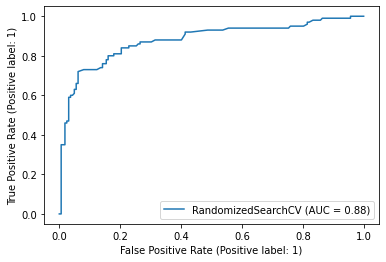

In [290]:
optimized_disp = RocCurveDisplay.from_estimator(random_search, X_test, y_test)

The **ROC curve** is a useful tool for evaluating the performance of a binary classifier, as it allows you to visualize the trade-off between the true positive rate and the false positive rate. A classifier that is more accurate will have a higher true positive rate and a lower false positive rate, resulting in a ROC curve that is closer to the top left corner of the plot. On the other hand, a classifier that is less accurate will have a lower true positive rate and a higher false positive rate, resulting in a ROC curve that is farther from the top left corner of the plot.

The **area under the ROC curve (AUC)** is a measure of the classifier's overall accuracy, with a value of 1.0 representing perfect accuracy and a value of 0.5 representing no better than random guessing. The AUC can be used to compare the performance of different classifiers, with a higher AUC indicating a better performing classifier.

### **Confusion matrix**

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


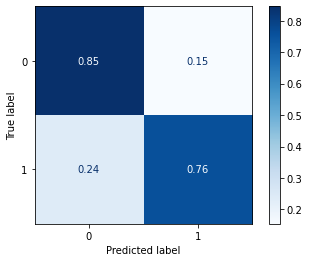

In [291]:
plot_confusion_matrix(random_search, X_test, y_test, cmap=plt.cm.Blues, normalize='true')
plt.show()

The confusion matrix shows that our model performs well to predict the death (True label = 0, Predicted label = 0) class and survival of those passengers who actually died (True label = 0, Predicted label = 1), but performs rather poorly on those who lived (True label = 1, Predicted labl = 1).

The confusion matrix is a useful tool for understanding the strengths and weaknesses of a model. The importance of the confusion matrix lies in the fact that it provides a detailed breakdown of the model's performance. For example, if the model is highly accurate but has a large number of false negatives, it might not be suitable for a task where it is important to identify all the positive samples. On the other hand, if the model has a large number of false positives, it might not be suitable for a task where it is important to avoid false alarms.